In [1]:
# Code repurposed for testing from 
#https://www.kaggle.com/kazmiekr/predicting-nhl-hall-of-famers/comments

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# master_df = pd.read_csv('Jeff/Output/test_train_file.csv')
#1967 onwards with skaters with >100 GP
master_df = pd.read_csv('Jeff/Output/tt_filt67_100GP_file.csv')
master_df.head()

Player    GP    G     A    TP    PPG   PIM  Years  POS  firstYear  \
0  Wayne Gretzky  1487  894  1963  2857  1.921   577     20    1       1979   
1   Mark Messier  1756  694  1193  1887  1.075  1910     25    1       1979   
2    Gordie Howe  1767  801  1049  1850  1.047  1685     26    1       1946   
3    Ron Francis  1731  549  1249  1798  1.039   979     23    1       1981   
4  Marcel Dionne  1348  731  1040  1771  1.314   600     18    1       1971   

   ...  Art Ross Awards  Conn Smythe Awards  Hart Awards  Calder Awards  \
0  ...               10                   2            9              0   
1  ...                0                   1            2              0   
2  ...                6                   0            6              0   
3  ...                0                   0            0              0   
4  ...                1                   0            0              0   

   James Norris Awards  Ted Lindsay Awards  Maurice Richard Awards  Cups  \
0                    0                   5                       0     4   
1                    0                   2                       0     0   
2                    0                   0                       0     4   
3                    0                   0                       0     2   
4                    0                   2                       0     0   

   All-Star Games  HoF  
0              18    1  
1              15    1  
2              23    1  
3               4    1  
4               8    1  

[5 rows x 21 columns]

In [4]:
master_df.columns

Index(['Player', 'GP', 'G', 'A', 'TP', 'PPG', 'PIM', 'Years', 'POS',
       'firstYear', 'lastYear', 'Art Ross Awards', 'Conn Smythe Awards',
       'Hart Awards', 'Calder Awards', 'James Norris Awards',
       'Ted Lindsay Awards', 'Maurice Richard Awards', 'Cups',
       'All-Star Games', 'HoF'],
      dtype='object')

In [5]:
new_hof = ['Jarome Iginla', 'Marian Hossa','Martin St. Louis','Teemu Selanne','Nicklas Lidstrom','Chris Pronger','Mark Recchi','Mike Modano','Peter Forsberg']
new_hof

['Jarome Iginla',
 'Marian Hossa',
 'Martin St. Louis',
 'Teemu Selanne',
 'Nicklas Lidstrom',
 'Chris Pronger',
 'Mark Recchi',
 'Mike Modano',
 'Peter Forsberg']

In [6]:
#drop hof additions since 2011 for testing purposes
inverse_boolean_series = ~master_df.Player.isin(new_hof)
retired_players = master_df[inverse_boolean_series]

retired_players = retired_players[retired_players['GP']>=100]

#create df with only new hof additions for testing
boolean_series = master_df.Player.isin(new_hof)
new_hof_df = master_df[boolean_series]
# print(new_hof_df)


initial_eligible_players = pd.read_csv('Jeff/Output/predict_file.csv')

#isolate any 'active' hof in the eligible players dataset
active_hof = initial_eligible_players[initial_eligible_players['HoF'] == 1]
# print(active_hof)
#append any 'active' hof players to the test set
new_hof_df = new_hof_df.append(active_hof)

#update the eligible players df
eligible_players = initial_eligible_players[initial_eligible_players['HoF'] == 0]
# print(new_hof_df)

In [7]:
cols_to_drop = ['Player','firstYear', 'POS', 'lastYear', 'HoF']

In [8]:
# print(new_hof_df)

In [9]:
target = 'HoF'
y = retired_players[target]
X = retired_players.drop(cols_to_drop, axis=1)

In [10]:
from sklearn.model_selection import train_test_split
#Train/test split, because I have a small imbalanced dataset I made sure to stratify my data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.9605


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
np.random.seed(42)

In [14]:
# Increasing hyperparameter C increases the accuracy score

log_model = make_pipeline(
       StandardScaler(),
       LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 50)
)

log_model.fit(X_train, y_train);

In [15]:
print('LOG: Training Accuracy Score:', log_model.score(X_train, y_train))
print('LOG: Validation Accuracy Score:', log_model.score(X_val, y_val))

LOG: Training Accuracy Score: 0.983
LOG: Validation Accuracy Score: 0.982


In [16]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(log_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for logistic regression');

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
#forest_model = RandomForestClassifier(max_depth=2, n_estimators=500)
forest_model = RandomForestClassifier(n_estimators=15)

forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15)

In [19]:
print('FOREST: Training Accuracy:', forest_model.score(X_train, y_train))
print('FOREST: VAl Accuracy:', forest_model.score(X_val, y_val))

FOREST: Training Accuracy: 1.0
FOREST: VAl Accuracy: 0.98


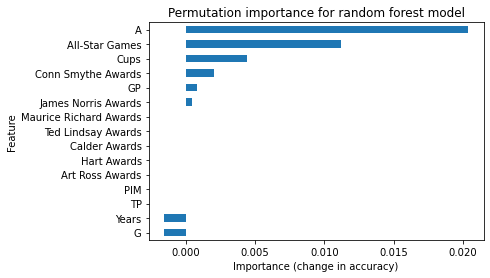

In [20]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(forest_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for random forest model');

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
boost_model = XGBClassifier(n_jobs=-1, random_state=42, n_estimators= 500, max_depth= 2, eta= 0.3, colsample_bytree= 0.6)

boost_model.fit(X_train, y_train);

C:\Users\Y243863\Anaconda3\envs\bcs\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
print('BOOST: Training accuracy:', boost_model.score(X_train, y_train))
print('BOOST: Val accuracy:', boost_model.score(X_val, y_val))

BOOST: Training accuracy: 1.0
BOOST: Val accuracy: 0.976


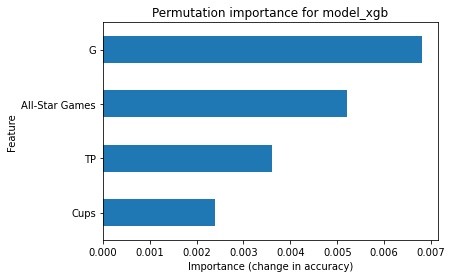

In [24]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(boost_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(4).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

In [25]:
from sklearn.metrics import plot_roc_curve

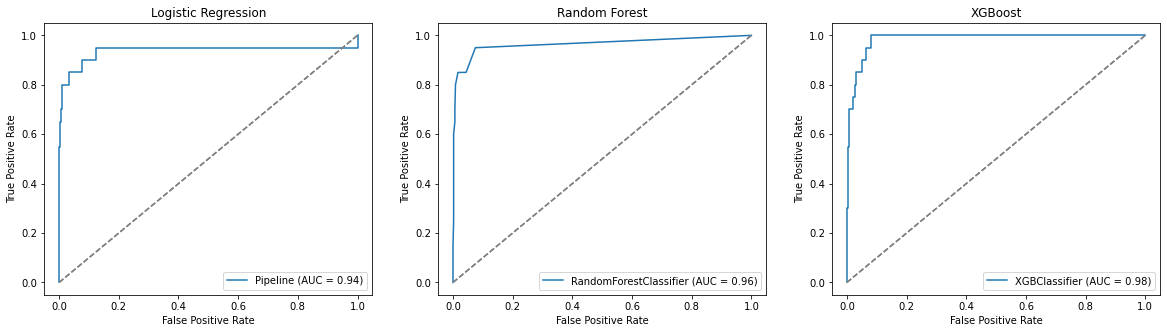

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

plot_roc_curve(log_model, X_val, y_val, ax=ax1)
plot_roc_curve(forest_model, X_val, y_val, ax=ax2)
plot_roc_curve(boost_model, X_val, y_val, ax=ax3)

ax1.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax2.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax3.plot([(0,0), (1,1)], color='grey', linestyle='--')


ax1.set_title('Logistic Regression')
ax2.set_title('Random Forest')
ax3.set_title('XGBoost')

plt.show()

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [28]:
xgboost_model1 = XGBClassifier()

param_space = {
         "max_depth": [1, 2, 3, 4],
         "eta": [0.3, 0.2, 0.1, 0.05, 0.01],
         "n_estimators": [100, 200, 300, 400, 500],
         "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1]
 }

xgboost_rand_search = RandomizedSearchCV(xgboost_model1, param_distributions=param_space, n_iter=20,
                                         scoring="accuracy", verbose=True, cv=StratifiedKFold(n_splits=5),
                                         n_jobs=-1, random_state=42)

xgboost_rand_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.8s finished
C:\Users\Y243863\Anaconda3\envs\bcs\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=No...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_

In [29]:
xgboost_rand_search.best_params_

{'n_estimators': 500, 'max_depth': 2, 'eta': 0.3, 'colsample_bytree': 0.6}

In [30]:
xgboost_rand_search.best_score_

0.8204

In [31]:
from scipy.stats import uniform, truncnorm, randint
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [32]:
rf_model1 = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model1, model_params, n_iter=100, cv=5, random_state=42)

# train the random search meta-estimator to find the best model out of 500 candidates
model = clf.fit(X, y)

# print winning set of hyperparameters
model.best_score_


0.8316000000000001

In [33]:
#Uncomment to use only active players

# cols_to_drop = ['firstYear','POS', 'lastYear', 'HoF']
# # target = 'HoF'
# # eligible_players.reset_index(drop=True)
# # eligible_players.set_index('Player')
# # eligible_players.head()
# X_test = eligible_players.drop(cols_to_drop, axis=1)
# X_test.set_index('Player', inplace=True)
# # X_test.set_index('Player')
# y_pred = clf.predict(X_test)

# results = pd.DataFrame(y_pred, columns=['HoF'], index=X_test.index)


In [60]:
#Use this cell for ALL players regardless of active status or GP
master_df = pd.read_csv('Jeff/Output/master_stats_file.csv')

cols_to_drop = ['firstYear','POS', 'lastYear', 'HoF']
# target = 'HoF'
# eligible_players.reset_index(drop=True)
# eligible_players.set_index('Player')
# eligible_players.head()
X_test = master_df.drop(cols_to_drop, axis=1)
X_test.set_index('Player', inplace=True)
# X_test.set_index('Player')
y_pred = model.predict(X_test)

results = pd.DataFrame(y_pred, columns=['HoF'], index=X_test.index)

In [58]:
# QBs the model predicts will be the next to enter the HOF

results[results['HoF'] == 1]

HoF
Player                 
Jaromir Jagr          1
Joe Thornton          1
Alexander Ovechkin    1
Sidney Crosby         1
Patrick Marleau       1
Yevgeni Malkin        1
Patrick Kane          1
Eric Staal            1
Steven Stamkos        1
Claude Giroux         1
Brent Burns           1
Zdeno Chara           1
Erik Karlsson         1

In [61]:
import shap
y_val.mean()

0.04

In [97]:
X_test = master_df.drop(cols_to_drop, axis=1)
X_test.set_index('Player', inplace=True)

y_pred = xgboost_rand_search.predict(X_test)

results = pd.DataFrame(y_pred, columns=['hof'], index=X_test.index)

player = 'Brett Hull'

row = X_test[X_test.index == player]

explainer = shap.TreeExplainer(boost_model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [91]:
# player = 'Alexander Steen'
model = forest_model
row = X_test[X_test.index == player]

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1], features=row)

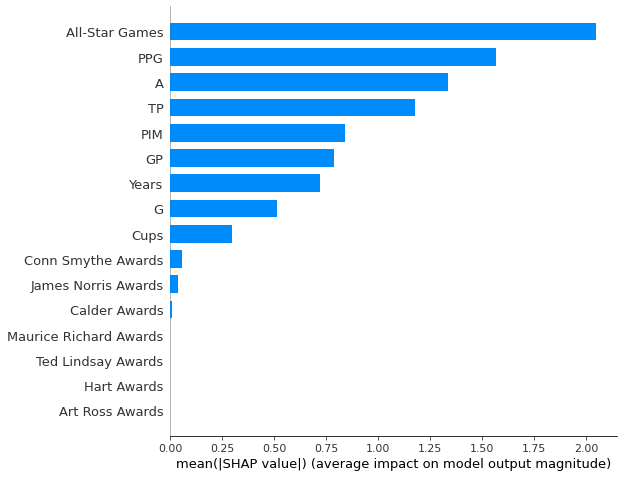

In [92]:
shap_values = shap.TreeExplainer(boost_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [93]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(boost_model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

GP    G     A    TP    PPG   PIM  Years  Art Ross Awards  \
Player                                                                        
Jaromir Jagr     1733  766  1155  1921  1.108  1167     24                5   
Sergei Fedorov   1248  483   696  1179  0.945   839     18                0   
Rick Tocchet     1144  440   512   952  0.832  2912     18                0   
Pierre Larouche   812  395   427   822  1.012   237     14                0   
Scott Gomez      1079  181   575   756  0.701   655     16                0   
Mike Bullard      755  336   358   694  0.919   741     11                0   
Robert Reichel    830  252   378   630  0.759   388     11                0   

                 Conn Smythe Awards  Hart Awards  Calder Awards  \
Player                                                            
Jaromir Jagr                      0            1              0   
Sergei Fedorov                    0            1              0   
Rick Tocchet                      0            0              0   
Pierre Larouche                   0            0              0   
Scott Gomez                       0            0              1   
Mike Bullard                      0            0              0   
Robert Reichel                    0            0              0   

                 James Norris Awards  Ted Lindsay Awards  \
Player                                                     
Jaromir Jagr                       0                   3   
Sergei Fedorov                     0                   1   
Rick Tocchet                       0                   0   
Pierre Larouche                    0                   0   
Scott Gomez                        0                   0   
Mike Bullard                       0                   0   
Robert Reichel                     0                   0   

                 Maurice Richard Awards  Cups  All-Star Games  predict  
Player                                                                  
Jaromir Jagr                          0     2              10        1  
Sergei Fedorov                        0     3               6        1  
Rick Tocchet                          0     1               4        0  
Pierre Larouche                       0     2               2        0  
Scott Gomez                           0     2               2        0  
Mike Bullard                          0     0               1        0  
Robert Reichel                        0     0               0        0

In [94]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(boost_model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [95]:
X_train.mean()

GP                        527.913000
G                          96.312500
A                         159.276500
TP                        255.589500
PPG                         0.409757
PIM                       496.087000
Years                       9.715500
Art Ross Awards             0.018500
Conn Smythe Awards          0.010500
Hart Awards                 0.016500
Calder Awards               0.013500
James Norris Awards         0.019500
Ted Lindsay Awards          0.008000
Maurice Richard Awards      0.001500
Cups                        0.335000
All-Star Games              0.619500
dtype: float64

In [41]:
shap_plot(0)

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

In [42]:
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [ ]:
shap_values = shap.TreeExplainer(forest_model).shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
y_val.mean()

In [98]:
!pip install jupyterthemes
!jt -r

Reset css and font defaults in:
C:\Users\Y243863\.jupyter\custom &
C:\Users\Y243863\AppData\Roaming\jupyter\nbextensions


In [100]:
!jt -r

Reset css and font defaults in:
C:\Users\Y243863\.jupyter\custom &
C:\Users\Y243863\AppData\Roaming\jupyter\nbextensions
